In [6]:
import json

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, RandomOverSampler

from catboost import CatBoostClassifier, CatBoostRegressor
from soreva_metrics import calculate_metrics, macro_averaged_mean_absolute_error

In [7]:
symps = [
         'artifact',
         'calcified cyst',
         'calcified vessels',
         'calcinates_benign',
         'calcinates_malignant',
         'fibrocystic_breast_changes',
         'lymphonodus',
         'mass_benign',
         'mass_malignant',
         'nipple',
         'papilloma',
         'pectoral muscle',
         'skin_thickening',
         'other'
        ]

In [8]:
def extract_basic_features(breast):
    
    predictors = {}

    
# ---------------------------------
# Every model and view


    for key in ['patient_id', 'laterality', 'tissue_density_predicted', 'cancer_probability_predicted']:
        predictors[key] = breast[key]
    
    for view in ["CC", "MLO"]:
        for modl in [1, 2, 3]:
            for symp in symps:
                for agg in ['min', 'max', 'mean', 'median', 'sum', 'count']:
                    predictors[view+'_'+str(modl)+'_'+symp+'_'+agg] = 0.0
                    
    for view in ["CC", "MLO"]:
        for modl in [1, 2, 3]:
            for symp in symps:
                for agg in ['min', 'max', 'mean', 'median', 'sum']:
                    predictors['square_'+view+'_'+str(modl)+'_'+symp+'_'+agg] = 0.0
                    
    for view in ["CC", "MLO"]:
        for modl in [1, 2, 3]:
            for symp in symps:
                for agg in ['min', 'max', 'mean', 'median', 'sum']:
                    predictors['prob_square_'+view+'_'+str(modl)+'_'+symp+'_'+agg] = 0.0
                    
#     for view in ["CC", "MLO"]:
#         for modl in [1, 2, 3]:
#             for symp in symps:
#                 for agg in ['min', 'max', 'mean', 'median']:
#                     predictors['xx_'+view+'_'+str(modl)+'_'+symp+'_'+agg] = 0.0
#                     predictors['yy_'+view+'_'+str(modl)+'_'+symp+'_'+agg] = 0.0

                
    for view in ["CC", "MLO"]:
        
        for modl in [1, 2, 3]:
        
            for symp in symps:
            
                objs_probs = [obj['probability'] for obj in breast[view] if symp in obj['object_type'] 
                              and obj['model_number'] == modl]
                
                objs_coords = [obj['coordinates'] for obj in breast[view] if symp in obj["object_type"]
                               and obj['model_number'] == modl]
            
                if objs_probs:
                    
                    predictors[view+'_'+str(modl)+'_'+symp+'_min'] = np.min(objs_probs)
                    predictors[view+'_'+str(modl)+'_'+symp+'_max'] = np.max(objs_probs)
                    predictors[view+'_'+str(modl)+'_'+symp+'_mean'] = np.mean(objs_probs)
                    predictors[view+'_'+str(modl)+'_'+symp+'_median'] = np.median(objs_probs)
                    predictors[view+'_'+str(modl)+'_'+symp+'_sum'] = np.sum(objs_probs)
                    predictors[view+'_'+str(modl)+'_'+symp+'_count'] = len(objs_probs)
                    
                    objs_squares = [(cord[2] - cord[0])*(cord[3] - cord[1]) for cord in objs_coords]
                    
                    predictors['square_'+view+'_'+str(modl)+'_'+symp+'_min'] = np.min(objs_squares)
                    predictors['square_'+view+'_'+str(modl)+'_'+symp+'_max'] = np.max(objs_squares)
                    predictors['square_'+view+'_'+str(modl)+'_'+symp+'_mean'] = np.mean(objs_squares)
                    predictors['square_'+view+'_'+str(modl)+'_'+symp+'_median'] = np.median(objs_squares)
                    predictors['square_'+view+'_'+str(modl)+'_'+symp+'_sum'] = np.sum(objs_squares)
                    
                    objs_probs_squares = [sq*prob for sq, prob in zip(objs_squares, objs_probs)]
                    
                    predictors['prob_square_'+view+'_'+str(modl)+'_'+symp+'_min'] = np.min(objs_probs_squares)
                    predictors['prob_square_'+view+'_'+str(modl)+'_'+symp+'_max'] = np.max(objs_probs_squares)
                    predictors['prob_square_'+view+'_'+str(modl)+'_'+symp+'_mean'] = np.mean(objs_probs_squares)
                    predictors['prob_square_'+view+'_'+str(modl)+'_'+symp+'_median'] = np.median(objs_probs_squares)
                    predictors['prob_square_'+view+'_'+str(modl)+'_'+symp+'_sum'] = np.sum(objs_probs_squares)
                    
#                     objs_xx = [(cord[2] + cord[0]) / 2 for cord in objs_coords]
                    
#                     predictors['xx_'+view+'_'+str(modl)+'_'+symp+'_min'] = np.min(objs_xx)
#                     predictors['xx_'+view+'_'+str(modl)+'_'+symp+'_max'] = np.max(objs_xx)
#                     predictors['xx_'+view+'_'+str(modl)+'_'+symp+'_mean'] = np.mean(objs_xx)
#                     predictors['xx_'+view+'_'+str(modl)+'_'+symp+'_median'] = np.median(objs_xx)
                    
#                     objs_yy = [(cord[3] + cord[1]) / 2 for cord in objs_coords]
                    
#                     predictors['yy_'+view+'_'+str(modl)+'_'+symp+'_min'] = np.min(objs_yy)
#                     predictors['yy_'+view+'_'+str(modl)+'_'+symp+'_max'] = np.max(objs_yy)
#                     predictors['yy_'+view+'_'+str(modl)+'_'+symp+'_mean'] = np.mean(objs_yy)
#                     predictors['yy_'+view+'_'+str(modl)+'_'+symp+'_median'] = np.median(objs_yy)
  
    
# ----------------------------------
# All models


#     for view in ["CC", "MLO"]:
#         for symp in symps:
#             for agg in ['min', 'max', 'mean', 'median', 'sum', 'count']:
#                 predictors[view+'_'+symp+'_'+agg] = 0.0
                
#     for view in ["CC", "MLO"]:
#         for symp in symps:
#             for agg in ['min', 'max', 'mean', 'median']:
#                 predictors['square_'+view+'_'+symp+'_'+agg] = 0.0
                    
#     for view in ["CC", "MLO"]:
#         for symp in symps:
#             for agg in ['min', 'max', 'mean', 'median', 'sum']:
#                 predictors['prob_square_'+view+'_'+symp+'_'+agg] = 0.0
                    
#     for view in ["CC", "MLO"]:
#         for symp in symps:
#             for agg in ['min', 'max', 'mean', 'median']:
#                 predictors['xx_'+view+'_'+symp+'_'+agg] = 0.0
#                 predictors['yy_'+view+'_'+symp+'_'+agg] = 0.0
                
#     for view in ["CC", "MLO"]:
        
#         for symp in symps:
        
#             objs_probs = [obj['probability'] for obj in breast[view] if symp in obj['object_type']]
            
#             objs_coords = [obj['coordinates'] for obj in breast[view] if symp in obj["object_type"]]
        
#             if objs_probs:
                
#                 predictors[view+'_'+symp+'_min'] = np.min(objs_probs)
#                 predictors[view+'_'+symp+'_max'] = np.max(objs_probs)
#                 predictors[view+'_'+symp+'_mean'] = np.mean(objs_probs)
#                 predictors[view+'_'+symp+'_median'] = np.median(objs_probs)
#                 predictors[view+'_'+symp+'_sum'] = np.sum(objs_probs)
#                 predictors[view+'_'+symp+'_count'] = len(objs_probs)
                
#                 objs_squares = [(cord[2] - cord[0])*(cord[3] - cord[1]) for cord in objs_coords]
                
#                 predictors['square_'+view+'_'+symp+'_min'] = np.min(objs_squares)
#                 predictors['square_'+view+'_'+symp+'_max'] = np.max(objs_squares)
#                 predictors['square_'+view+'_'+symp+'_mean'] = np.mean(objs_squares)
#                 predictors['square_'+view+'_'+symp+'_median'] = np.median(objs_squares)
                
#                 objs_probs_squares = [cord*prob for cord, prob in zip(objs_squares, objs_probs)]
                
#                 predictors['prob_square_'+view+'_'+symp+'_min'] = np.min(objs_probs_squares)
#                 predictors['prob_square_'+view+'_'+symp+'_max'] = np.max(objs_probs_squares)
#                 predictors['prob_square_'+view+'_'+symp+'_mean'] = np.mean(objs_probs_squares)
#                 predictors['prob_square_'+view+'_'+symp+'_median'] = np.median(objs_probs_squares)
#                 predictors['prob_square_'+view+'_'+symp+'_sum'] = np.sum(objs_probs_squares)
                
#                 objs_xx = [(cord[2] + cord[0]) / 2 for cord in objs_coords]
                
#                 predictors['xx_'+view+'_'+symp+'_min'] = np.min(objs_xx)
#                 predictors['xx_'+view+'_'+symp+'_max'] = np.max(objs_xx)
#                 predictors['xx_'+view+'_'+symp+'_mean'] = np.mean(objs_xx)
#                 predictors['xx_'+view+'_'+symp+'_median'] = np.median(objs_xx)
                
#                 objs_yy = [(cord[3] + cord[1]) / 2 for cord in objs_coords]
                
#                 predictors['yy_'+view+'_'+symp+'_min'] = np.min(objs_yy)
#                 predictors['yy_'+view+'_'+symp+'_max'] = np.max(objs_yy)
#                 predictors['yy_'+view+'_'+symp+'_mean'] = np.mean(objs_yy)
#                 predictors['yy_'+view+'_'+symp+'_median'] = np.median(objs_yy)

                
# ----------------------------------
# All models and views


#     for symp in symps:
#         for agg in ['min', 'max', 'mean', 'median', 'sum', 'count']:
#             predictors[symp+'_'+agg] = 0.0
                
#     for symp in symps:
#         for agg in ['min', 'max', 'mean', 'median']:
#             predictors['square_'+symp+'_'+agg] = 0.0
                    
#     for symp in symps:
#         for agg in ['min', 'max', 'mean', 'median', 'sum']:
#             predictors['prob_square_'+symp+'_'+agg] = 0.0
                    
#     for symp in symps:
#         for agg in ['min', 'max', 'mean', 'median']:
#             predictors['xx_'+symp+'_'+agg] = 0.0
#             predictors['yy_'+symp+'_'+agg] = 0.0
        
#     for symp in symps:
        
#         objs_probs = [obj['probability'] for obj in breast['CC'] if symp in obj['object_type']]
#         [objs_probs.append(obj['probability']) for obj in breast['MLO'] if symp in obj['object_type']]
        
#         objs_coords = [obj['coordinates'] for obj in breast['CC'] if symp in obj['object_type']]
#         [objs_coords.append(obj['coordinates']) for obj in breast['MLO'] if symp in obj['object_type']]
    
#         if objs_probs:
            
#             predictors[symp+'_min'] = np.min(objs_probs)
#             predictors[symp+'_max'] = np.max(objs_probs)
#             predictors[symp+'_mean'] = np.mean(objs_probs)
#             predictors[symp+'_median'] = np.median(objs_probs)
#             predictors[symp+'_sum'] = np.sum(objs_probs)
#             predictors[symp+'_count'] = len(objs_probs)
            
#             objs_squares = [(cord[2] - cord[0])*(cord[3] - cord[1]) for cord in objs_coords]
            
#             predictors['square_'+symp+'_min'] = np.min(objs_squares)
#             predictors['square_'+symp+'_max'] = np.max(objs_squares)
#             predictors['square_'+symp+'_mean'] = np.mean(objs_squares)
#             predictors['square_'+symp+'_median'] = np.median(objs_squares)
            
#             objs_probs_squares = [cord*prob for cord, prob in zip(objs_squares, objs_probs)]
            
#             predictors['prob_square_'+symp+'_min'] = np.min(objs_probs_squares)
#             predictors['prob_square_'+symp+'_max'] = np.max(objs_probs_squares)
#             predictors['prob_square_'+symp+'_mean'] = np.mean(objs_probs_squares)
#             predictors['prob_square_'+symp+'_median'] = np.median(objs_probs_squares)
#             predictors['prob_square_'+symp+'_sum'] = np.sum(objs_probs_squares)
            
#             objs_xx = [(cord[2] + cord[0]) / 2 for cord in objs_coords]
            
#             predictors['xx_'+symp+'_min'] = np.min(objs_xx)
#             predictors['xx_'+symp+'_max'] = np.max(objs_xx)
#             predictors['xx_'+symp+'_mean'] = np.mean(objs_xx)
#             predictors['xx_'+symp+'_median'] = np.median(objs_xx)
            
#             objs_yy = [(cord[3] + cord[1]) / 2 for cord in objs_coords]
            
#             predictors['yy_'+symp+'_min'] = np.min(objs_yy)
#             predictors['yy_'+symp+'_max'] = np.max(objs_yy)
#             predictors['yy_'+symp+'_mean'] = np.mean(objs_yy)
#             predictors['yy_'+symp+'_median'] = np.median(objs_yy)

                
# ----------------------------------
# All models and views and symps


#     for agg in ['min', 'max', 'mean', 'median', 'sum', 'count']:
#         predictors[agg] = 0.0
                
#     for agg in ['min', 'max', 'mean', 'median']:
#         predictors['square_'+agg] = 0.0
                    
#     for agg in ['min', 'max', 'mean', 'median', 'sum']:
#         predictors['prob_square_'+agg] = 0.0
        
#     objs_probs = [obj['probability'] for obj in breast['CC']]
#     [objs_probs.append(obj['probability']) for obj in breast['MLO']]
    
#     objs_coords = [obj['coordinates'] for obj in breast['CC']]
#     [objs_coords.append(obj['coordinates']) for obj in breast['MLO']]
    
#     if objs_probs:
        
#         predictors['min'] = np.min(objs_probs)
#         predictors['max'] = np.max(objs_probs)
#         predictors['mean'] = np.mean(objs_probs)
#         predictors['median'] = np.median(objs_probs)
#         predictors['sum'] = np.sum(objs_probs)
#         predictors['count'] = len(objs_probs)
        
#         objs_squares = [(cord[2] - cord[0])*(cord[3] - cord[1]) for cord in objs_coords]
        
#         predictors['square_'+'min'] = np.min(objs_squares)
#         predictors['square_'+'max'] = np.max(objs_squares)
#         predictors['square_'+'mean'] = np.mean(objs_squares)
#         predictors['square_'+'median'] = np.median(objs_squares)
        
#         objs_probs_squares = [cord*prob for cord, prob in zip(objs_squares, objs_probs)]
        
#         predictors['prob_square_'+'min'] = np.min(objs_probs_squares)
#         predictors['prob_square_'+'max'] = np.max(objs_probs_squares)
#         predictors['prob_square_'+'mean'] = np.mean(objs_probs_squares)
#         predictors['prob_square_'+'median'] = np.median(objs_probs_squares)
#         predictors['prob_square_'+'sum'] = np.sum(objs_probs_squares)
        
    return predictors

In [9]:
with open("data_train/data_train.json", "r") as fin:
    data_train = json.load(fin)

targets_train = pd.read_csv("data_train/targets_train.csv", index_col=0)

predictors = {}
for key, value in tqdm(data_train.items()):
    predictors[key] = extract_basic_features(value)

df_train = pd.DataFrame.from_dict(predictors, orient="index")
df_train = pd.merge(df_train, targets_train, left_index=True, right_index=True)

df_train.loc[df_train.laterality == 'L', 'laterality'] = 0
df_train.loc[df_train.laterality == 'R', 'laterality'] = 1
df_train['laterality'] = df_train['laterality'].astype(int)

100%|██████████████████████████████████████| 4063/4063 [00:18<00:00, 223.99it/s]


In [10]:
# train_columns = df_train[df_train.columns[1:-1]].columns

In [11]:
# df_train[['another_'+x for x in train_columns]] = 0

# for i in tqdm(range(df_train.shape[0])):
    
#     pid = df_train.patient_id.iloc[i]
#     lat = df_train.laterality.iloc[i]
    
#     try:
    
#         df_train.loc[(df_train.patient_id == pid)
#                      &(df_train.laterality == lat), ['another_'+x for x in train_columns]] \
#         = df_train.loc[(df_train.patient_id == pid)
#                        &(df_train.laterality != lat), train_columns].iloc[0].values
        
#     except:
        
#         pass

In [12]:
df_train.groupby('BiRads').laterality.count()

BiRads
1    1490
2    2419
3     104
4      44
5       6
Name: laterality, dtype: int64

In [13]:
X = df_train.drop(['patient_id', 'BiRads',
#                   'laterality'
                  ], axis=1)
y = df_train['BiRads']

In [14]:
X.shape

(4063, 1347)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1)

In [17]:
# model = GradientBoostingClassifier()
# model.fit(X_train, y_train)

# # ExtraTreesClassifier, GradientBoostingClassifier, SVC

In [18]:
model = CatBoostClassifier(loss_function='MultiClass',
#                            auto_class_weights='Balanced',
#                            depth=6, iterations=2000,
#                            l2_leaf_reg=1,
#                            random_strength=10, 
#                            bagging_temperature=10,
                           early_stopping_rounds=250, verbose=100)

model.fit(X_train, y_train, eval_set=(X_val, y_val),
          cat_features=['laterality', 
#                         'another_laterality'
                       ]
         )

Learning rate set to 0.110812
0:	learn: 1.4564512	test: 1.4509765	best: 1.4509765 (0)	total: 330ms	remaining: 5m 29s
100:	learn: 0.5550685	test: 0.7196011	best: 0.7193874 (98)	total: 11.2s	remaining: 1m 39s
200:	learn: 0.3982348	test: 0.7291420	best: 0.7180276 (107)	total: 21.8s	remaining: 1m 26s
300:	learn: 0.2985240	test: 0.7348539	best: 0.7180276 (107)	total: 31.6s	remaining: 1m 13s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.7180275545
bestIteration = 107

Shrink model to first 108 iterations.


In [19]:
# models = []

# for train_index, test_index in StratifiedKFold(n_splits=5).split(df_train, df_train['BiRads']):
    
#     X_train, y_train = df_train.drop(['BiRads'], axis=1).iloc[train_index], df_train['BiRads'].iloc[train_index]
    
#     X_val, y_val = df_train.drop(['BiRads'], axis=1).iloc[test_index], df_train['BiRads'].iloc[test_index]
    
#     model = CatBoostClassifier(loss_function='MultiClass',
#                                early_stopping_rounds=250,
#                                verbose=100)

#     model.fit(X_train, y_train, eval_set=(X_val, y_val),
#               cat_features=['laterality'])
    
#     print(calculate_metrics(y_val, model.predict(X_val)))
    
#     models.append(model)

In [20]:
# preds = np.zeros((X_val.shape[0], 5))

# for model in models:
    
#     preds += model.predict_proba(X_val) / 5

In [21]:
preds = model.predict_proba(X_val)

In [22]:
preds[:, 4].max()

0.030836050274570405

In [23]:
preds_ = []

for pred in preds:
    
    max_pred = np.where(pred == pred.max())[0][0]
    
    if pred[4] > 0.005:
        preds_.append(5)
    
    elif pred[3] > 0.01:
        preds_.append(4)
    
    elif pred[2] > 0.015:
        preds_.append(3)
    
    else:
        preds_.append(max_pred+1)

In [24]:
preds2 = []

for pred in preds:
    
    pred2 = np.zeros((5))
    
    for i in range(5):
        for j in range(i+1):
            if j == 2:
                pred2[i] += 1.4*pred[j] / (i+1)
            elif j == 3:
                pred2[i] += 1.8*pred[j] / (i+1)
            elif j == 4:
                pred2[i] += 2.2*pred[j] / (i+1)
            else:
                pred2[i] += pred[j] / (i+1)
    
    preds2.append(pred2)

In [25]:
preds_ = []
for pred in preds2:
    max_pred = np.where(pred == pred.max())[0][0]
    preds_.append(max_pred+1)

In [26]:
calculate_metrics(y_val, np.array(preds_)) + 0.25*macro_averaged_mean_absolute_error(y_val, np.array(preds_))

0.2049091847749566

In [27]:
0.25*macro_averaged_mean_absolute_error(y_val, np.array(preds_))

0.33340451494813916

In [28]:
calculate_metrics(y_val, np.array(preds_))

-0.12849533017318257

In [29]:
calculate_metrics(y_val, model.predict(X_val))

-0.12849533017318257

In [109]:
with open("data_test/data_test.json", "r") as fin:
    data_test = json.load(fin)

predictors_test = {}
for key, value in tqdm(data_test.items()):
    predictors_test[key] = extract_basic_features(value)

df_test = pd.DataFrame.from_dict(predictors_test, orient="index")

df_test.loc[df_test.laterality == 'L', 'laterality'] = 0
df_test.loc[df_test.laterality == 'R', 'laterality'] = 1
df_test['laterality'] = df_test['laterality'].astype(int)

100%|██████████████████████████████████████| 4663/4663 [00:20<00:00, 225.21it/s]


In [523]:
df_test = df_test.drop(['patient_id'], axis=1)

In [524]:
# df_test[['another_'+x for x in train_columns]] = 0

# for i in tqdm(range(df_test.shape[0])):
    
#     pid = df_test.patient_id.iloc[i]
#     lat = df_test.laterality.iloc[i]
    
#     try:
    
#         df_test.loc[(df_test.patient_id == pid)
#                      &(df_test.laterality == lat), ['another_'+x for x in train_columns]] \
#         = df_test.loc[(df_test.patient_id == pid)
#                        &(df_test.laterality != lat), train_columns].iloc[0].values
        
#     except:
        
#         pass

In [525]:
# preds = np.zeros((df_test.shape[0], 5))

# for model in models:
#     preds += model.predict_proba(df_test) / len(models)

In [526]:
preds = model.predict_proba(df_test)

In [527]:
# for i in range(5):
#     preds[:, i] = (preds[:, i] - preds[:, i].min()) / (preds[:, i].max() - preds[:, i].min())

In [528]:
preds[:, 4].max()

0.3691250093934651

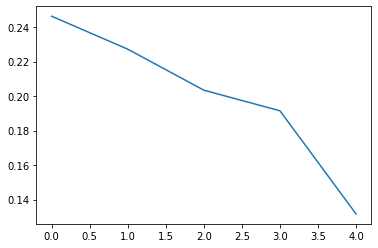

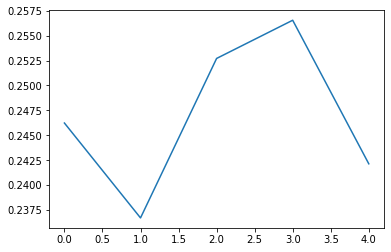

In [546]:
k = 5
plt.plot(preds[k])
plt.show()
plt.plot(preds2[k])
plt.show()

In [680]:
preds2 = []

for pred in preds:
    
    pred2 = np.zeros((5))
    
    for i in range(5):
        for j in range(i+1):
            if j == 2:
                pred2[i] += 1.3*pred[j] / (i+1)
            elif j == 3:
                pred2[i] += 1.2*pred[j] / (i+1)
            elif j == 4:
                pred2[i] += 1.5*pred[j] / (i+1)
            else:
                pred2[i] += pred[j] / (i+1)
    
    preds2.append(pred2)

In [681]:
preds_ = []
for pred in preds2:
    max_pred = np.where(pred == pred.max())[0][0]
    preds_.append(max_pred+1)

In [753]:
preds_ = []

for pred in preds:
    
    max_pred = np.where(pred == pred.max())[0][0]
    
    if pred[4] > 0.21:
        preds_.append(5)
    
    elif pred[3] > 0.23:
        preds_.append(4)
    
    elif pred[2] > 0.22:
        preds_.append(3)
    
    else:
        preds_.append(max_pred+1)

In [754]:
# preds_ = model.predict(df_test)

In [755]:
sub = pd.read_csv('sample_submit.csv')

In [756]:
sub['BiRads'] = preds_
sub['best'] = pd.read_csv('sub_18.csv')['BiRads']

In [757]:
sub.groupby('BiRads').id.count()

BiRads
1    1872
2     744
3     984
4     854
5     209
Name: id, dtype: int64

In [758]:
sub.groupby('best').id.count()

best
1     937
2    1175
3    1034
4    1303
5     214
Name: id, dtype: int64

In [759]:
# min_diff = 2000

# for t1 in [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]:
    
#     for t2 in [0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]:
        
#         for t3 in [0.008, 0.009, 0.01, 0.011, 0.012, 0.013]:

#             preds_ = []
            
#             for pred in preds:
                
#                 max_pred = np.where(pred == pred.max())[0][0]
                
#                 if pred[4] > t1:
#                     preds_.append(5)
                
#                 elif pred[3] > t2:
#                     preds_.append(4)
                
#                 elif pred[2] > t3:
#                     preds_.append(3)
                
#                 else:
#                     preds_.append(max_pred+1)
                    
#             sub['BiRads'] = preds_
            
#             if sub[sub.BiRads != sub.best].shape[0] < min_diff:
#                 min_diff = sub[sub.BiRads != sub.best].shape[0]
#                 print(t1, t2, t3, sub[sub.BiRads != sub.best].shape)

In [760]:
sub[sub.BiRads != sub.best].shape

(2798, 3)

In [761]:
sub[['id', 'BiRads']].to_csv('sub_49.csv', index=False)

In [615]:
preds[preds[:, 0] > 0.25].shape

(1524, 5)

In [161]:
# fimp = np.zeros((df_train.shape[1]-1))

# for model in models:
    
#     fimp += model.get_feature_importance() / 5

In [49]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns
feature_importance['importance'] = model.get_feature_importance()
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
# feature_importance['importance'] = fimp

In [51]:
# feature_importance[feature_importance.importance > 0].sort_values('importance', ascending=False).shape[0]

In [58]:
def feature_type(feature):
    if 'prob_square' in feature:
        return 'prob_square'
    elif 'square' in feature:
        return 'square'
    else:
        return 'prob'
    
def feature_model(feature):
    if '1' in feature:
        return 1
    elif '2' in feature:
        return 2
    else:
        return 3

In [59]:
feature_importance['type'] = feature_importance.feature.apply(lambda x: feature_type(x))
feature_importance['model'] = feature_importance.feature.apply(lambda x: feature_model(x))

In [80]:
feature_importance[feature_importance.type == 'square'].head(10)

,feature,importance,type,model
5,square_MLO_3_mass_malignant_sum,0.984293,square,3
8,square_MLO_1_lymphonodus_max,0.815685,square,1
11,square_MLO_1_nipple_sum,0.779411,square,1
14,square_CC_1_calcinates_benign_mean,0.739846,square,1
17,square_CC_3_mass_benign_mean,0.675747,square,3
22,square_MLO_2_mass_malignant_median,0.645050,square,2
24,square_CC_2_mass_malignant_mean,0.630174,square,2
25,square_MLO_1_calcinates_benign_mean,0.629509,square,1
27,square_MLO_1_calcinates_benign_sum,0.614917,square,1
29,square_MLO_1_pectoral muscle_mean,0.602058,square,1


In [ ]:
# prob_square median - 589.5
# square median - 544.5
# prob median - 908

In [502]:
# feature_importance.sort_values('importance', ascending=False).iloc[:50]

In [811]:
X_feat = X[feature_importance[feature_importance.importance > 0.0001].feature.values]
y_feat = y

In [812]:
X_train, X_val, y_train, y_val = train_test_split(X_feat, y_feat, stratify=y_feat, test_size=0.15)

In [813]:
model = CatBoostClassifier(loss_function='MultiClass', early_stopping_rounds=250, verbose=100)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.110686
0:	learn: 1.4641425	test: 1.4705180	best: 1.4705180 (0)	total: 261ms	remaining: 4m 20s
100:	learn: 0.5180438	test: 0.7306986	best: 0.7297976 (98)	total: 12.7s	remaining: 1m 53s
200:	learn: 0.3542670	test: 0.7336471	best: 0.7277790 (115)	total: 25.6s	remaining: 1m 41s
300:	learn: 0.2518778	test: 0.7358142	best: 0.7277790 (115)	total: 37.3s	remaining: 1m 26s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.7277789616
bestIteration = 115

Shrink model to first 116 iterations.


In [814]:
# models = []

# for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
    
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    
#     X_val, y_val = X.iloc[test_index], y.iloc[test_index]
    
#     model = CatBoostClassifier(loss_function='MultiClass',
#                                early_stopping_rounds=250,
#                                verbose=False)

#     model.fit(X_train, y_train, eval_set=(X_val, y_val),
# #               cat_features=['laterality']
#              )
    
#     print(calculate_metrics(y_val, model.predict(X_val)))
    
#     models.append(model)

In [178]:
# preds = np.zeros((df_test.shape[0], 5))

# for model in models:
#     preds += model.predict_proba(df_test[feature_importance[feature_importance.importance > 0.05].feature.values]) / len(models)

In [839]:
preds = model.predict_proba(df_test[feature_importance[feature_importance.importance > 0.0001].feature.values])

preds_ = []

for pred in preds:
    
    max_pred = np.where(pred == pred.max())[0][0]
    
    if pred[4] > 0.005:
        preds_.append(5)
    
    elif pred[3] > 0.01:
        preds_.append(4)
    
    elif pred[2] > 0.015:
        preds_.append(3)
    
    else:
        preds_.append(max_pred+1)

In [840]:
sub = pd.read_csv('sample_submit.csv')

In [841]:
# sub['BiRads'] = preds_
sub['BiRads'] = preds_
sub['best'] = pd.read_csv('sub_18.csv')['BiRads']

In [842]:
sub.groupby('BiRads').id.count()

BiRads
1     795
2    1001
3    1362
4    1278
5     227
Name: id, dtype: int64

In [843]:
sub.groupby('best').id.count()

best
1     937
2    1175
3    1034
4    1303
5     214
Name: id, dtype: int64

In [844]:
sub[['id', 'BiRads']].to_csv('sub_30.csv', index=False)

In [845]:
sub[sub.BiRads != sub.best]

,id,BiRads,best
0,8097d218-2c51-4ec8-9ee8-ea6b7701ef3c,3,4
1,4c9a6bed-a454-467c-b51e-451f5ee2db35,4,3
7,f572edaa-93ce-4489-80e2-0fad155e5851,2,1
9,6aba217f-bbaf-4368-9b30-64b481177c80,4,3
10,9a13ff22-f414-457b-8e01-e11adea327a9,3,4
...,...,...,...
4653,a71181a4-a11f-49cb-b997-bacbc65123f3,3,4
4656,a83040a4-6949-4915-a863-1a185de4551a,3,2
4658,67db950f-8a39-4594-82a4-6b22db8afb76,4,5
4660,eb0a4b02-1d68-4b62-bcaa-1825ce5804d2,3,4


In [3]:
ress = [0.1753, 0.1799, 0.1694, 0.1945,
        0.1514, 0.1856, 0.2661, 0.1815, 0.2104,
        0.2241, 0.2009, 0.2309, 0.2031, 0.2043]

In [12]:
sub = pd.read_csv('sample_submit.csv')

In [37]:
preds = np.zeros((sub.shape[0], 5))

for i in range(11, 25):

    pred_temp = pd.read_csv('sub_{}.csv'.format(i))['BiRads']
    
    for j, pr in enumerate(pred_temp):
        
#         preds[j, pr-1] += ress[i-11]
        preds[j, pr-1] += 1

In [38]:
np.where(pred == np.sort(pred)[-2])[0][0]

3

In [43]:
preds_ = []

for pred in preds:
    
    max_pred = np.where(pred == np.sort(pred)[-1])[0][0]
    premax_pred = np.where(pred == np.sort(pred)[-2])[0][0]
    
    if max_pred - premax_pred < 3:
        preds_.append(min(max_pred, premax_pred)+1)
    else:
        preds_.append(max_pred+1)

In [44]:
sub['BiRads'] = preds_
sub['best'] = pd.read_csv('sub_18.csv')['BiRads']

In [45]:
sub[sub.BiRads != sub.best]

,id,BiRads,best
0,8097d218-2c51-4ec8-9ee8-ea6b7701ef3c,2,4
1,4c9a6bed-a454-467c-b51e-451f5ee2db35,4,3
6,c36553d6-0d4a-42d6-a86c-7c8c84049528,2,3
8,8eea4d43-8c24-4e7e-b542-fef9fe477ec5,4,5
10,9a13ff22-f414-457b-8e01-e11adea327a9,3,4
...,...,...,...
4653,a71181a4-a11f-49cb-b997-bacbc65123f3,3,4
4655,6805a0e5-306a-4985-a391-ead1b94208d8,3,4
4656,a83040a4-6949-4915-a863-1a185de4551a,1,2
4660,eb0a4b02-1d68-4b62-bcaa-1825ce5804d2,3,4


In [46]:
sub[['id', 'BiRads']].to_csv('sub_41.csv', index=False)

In [86]:
# 11 - 24
df = pd.DataFrame()
for i in range(11, 25):
    df[i] = pd.read_csv('sub_{}.csv'.format(i)).groupby('BiRads').id.count()

In [91]:
np.round(df.std(axis=1))

BiRads
1     42.0
2    104.0
3    131.0
4    112.0
5    133.0
dtype: float64